# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [3]:
# Load the dataset
netcdf_file_path = "Data/24_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T04:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:45:58
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

### Convert the dataset to a pandas DataFrame

In [4]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove rows where 'u' has NaN values
df = df.dropna(subset=['u'])
df = df.dropna(subset=['v'])

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.6908,-0.187088,-0.048105
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.7314,-0.250971,-0.024680
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.6908,-0.394889,0.063383
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1230,0.327331,-0.174509
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1635,0.400850,-0.164626
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.2041,0.460808,-0.139945


### Geospatial Visualization
Define boundaries and coordinates for visualization

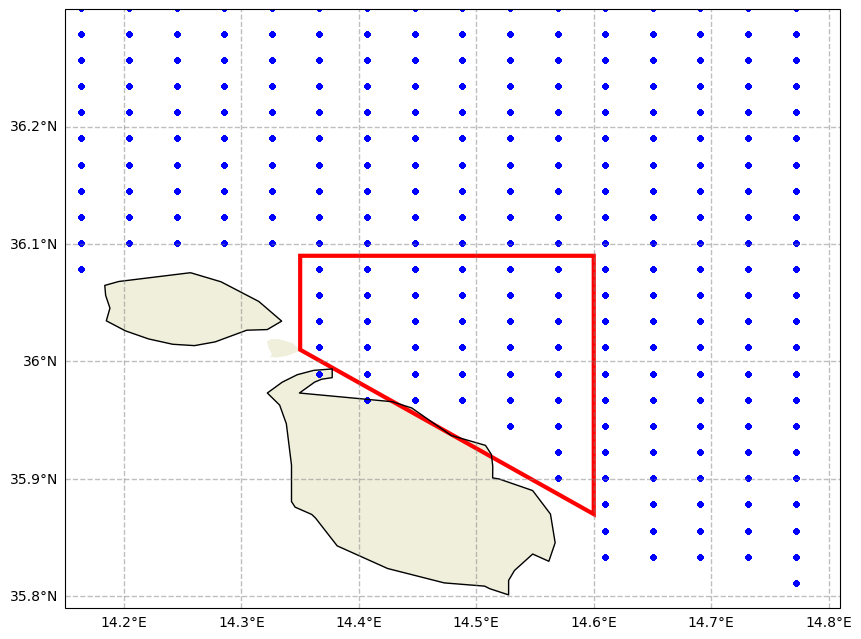

In [5]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Filtering 
Filter the DataFrame to include only data points within the specified polygon.

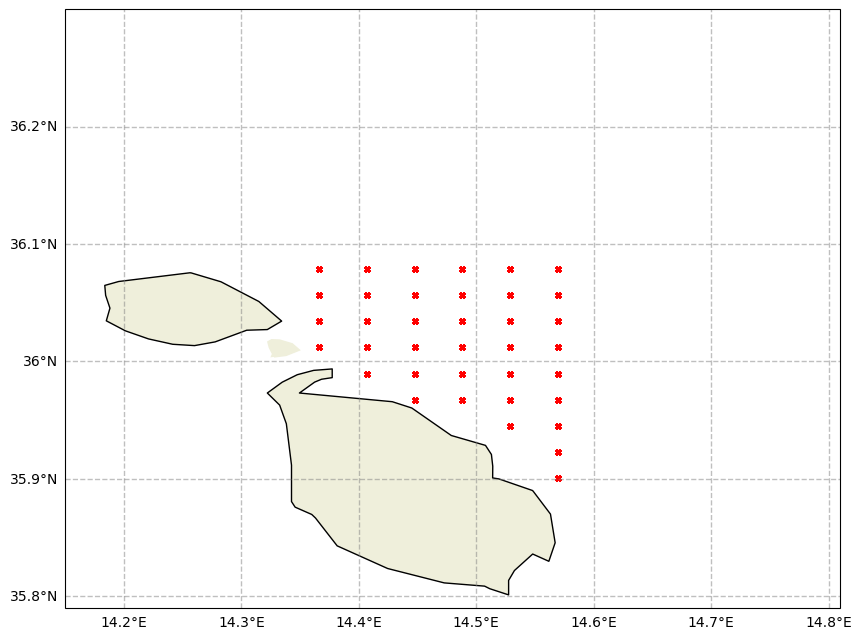

In [6]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Preparation

In [7]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.528599739074707, 36.07870101928711)
(14.569199562072754, 36.07870101928711)
(14.447500228881836, 36.07870101928711)
(14.447500228881836, 36.056400299072266)
(14.406900405883789, 36.07870101928711)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.48799991607666, 36.07870101928711)
(14.48799991607666, 36.03409957885742)
(14.48799991607666, 36.056400299072266)
(14.569199562072754, 35.96730041503906)
(14.569199562072754, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.48799991607666, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.447500228881836, 36.01190185546875)
(14.366399765014648, 36.07870101928711)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.9

In [8]:
# Assuming 'inside_mask' is a list of booleans indicating whether each point is inside the polygon
inside_mask = [polygon_path.contains_point((lon, lat)) for lon, lat in zip(df['lon'], df['lat'])]

# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the resulting DataFrame
final_df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5286,0.046379,0.059340
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5692,-0.235254,0.081921
2021-01-01 00:00:00,2021-01-01 00:00:00,36.078701,14.5286,0.023732,0.085635
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4069,-0.147110,-0.092706
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4475,-0.092843,-0.124476
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4880,-0.047441,-0.130120


### Exctract data only for a single pair of coordinates

In [9]:
# Coordinates 
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame for the exact coordinates
df_point = final_df[(final_df['lat'] == target_lat) & (final_df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.0341,14.5286,0.079402,0.039575
2021-01-01 13:00:00,2021-01-01 13:00:00,36.0341,14.5286,0.162881,-0.039021
2021-01-01 14:00:00,2021-01-01 14:00:00,36.0341,14.5286,0.144165,-0.023481
2021-01-01 15:00:00,2021-01-01 15:00:00,36.0341,14.5286,0.280085,-0.033406
2021-01-01 16:00:00,2021-01-01 16:00:00,36.0341,14.5286,0.115884,-0.089223
...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31 19:00:00,36.0341,14.5286,0.003522,-0.170710
2022-12-31 20:00:00,2022-12-31 20:00:00,36.0341,14.5286,0.000774,-0.120463
2022-12-31 21:00:00,2022-12-31 21:00:00,36.0341,14.5286,-0.030468,-0.092138


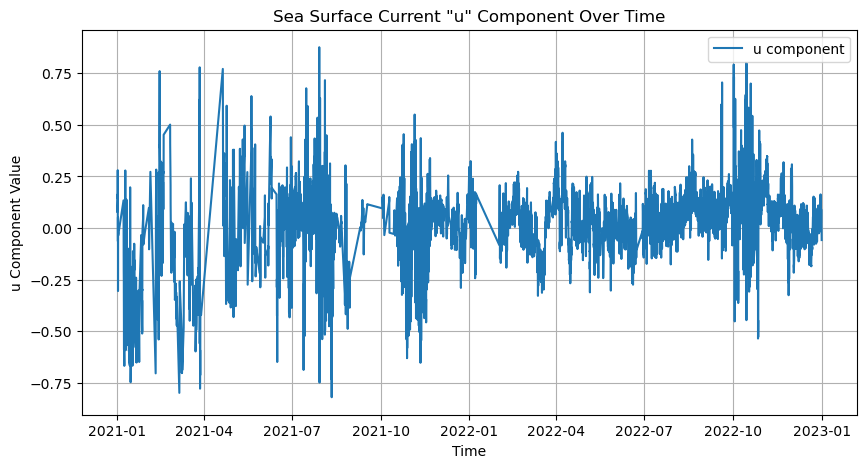

In [10]:
df1_u = df_point['u']

plt.figure(figsize=(10, 5))  
plt.plot(df1_u.index, df1_u, label='u component')  
plt.title('Sea Surface Current "u" Component Over Time')  
plt.xlabel('Time')  
plt.ylabel('u Component Value')  
plt.legend()  
plt.grid(True)  
plt.show()

### Convert the time series data into a format suitable for LSTM

In [11]:
def df_to_X_y(df_u, df_v, window_size=5):
    df_u_as_np = df_u.to_numpy()
    df_v_as_np = df_v.to_numpy()
    X = [] 
    y = []
    for i in range(len(df_u_as_np) - window_size):
        # Create a combined feature for each time step in the window
        combined_features = [[df_u_as_np[i+j], df_v_as_np[i+j]] for j in range(window_size)]
        X.append(combined_features)
        # The target remains the 'u' value at the next time step
        label = df_u_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 1
X, y = df_to_X_y(df_point['u'], df_point['v'], window_size=window_size)
X.shape, y.shape

((8846, 1, 2), (8846,))

### Split the data

In [12]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    # Calculate the indices for the end of each segment
    total_size = len(X)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    
    # Split the data
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

train_size = 0.70
val_size = 0.15
test_size = 1 - (train_size + val_size)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size, val_size, test_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6192, 1, 2), (6192,), (1326, 1, 2), (1326,), (1328, 1, 2), (1328,))

### Define & Compile the Model

In [13]:
# Define the model
model = Sequential()
model.add(InputLayer((window_size, 2)))
model.add(LSTM(128, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(64, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(32))  
model.add(Dropout(0.2))  
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dense(1, activation='linear'))

model.summary()

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_single_u_target_diff_sequence_best_model",
                     save_best_only=True,
                     monitor='val_loss',  
                     mode='min',
                     verbose=0)   

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True,
                               min_delta=0.0001,  
                               verbose=1)             

# Compile the model
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            67072     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                

### Train the Model

Epoch 1/100

618/620 [============================>.] - ETA: 0s - loss: 0.0537INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 21s 22ms/step - loss: 0.0536 - val_loss: 0.0126
Epoch 2/100
615/620 [============================>.] - ETA: 0s - loss: 0.0120INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 14s 23ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 3/100
620/620 [==============================] - 5s 8ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch 4/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 5/100
620/620 [==============================] - 5s 8ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 6/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0113 - val_loss: 0.0118
Epoch 7/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 8/100
620/620 [==============================] - 3s 6ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 9/100
618/620 [============================>.] - ETA: 0s - loss: 0.0113INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 11s 18ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 10/100
619/620 [============================>.] - ETA: 0s - loss: 0.0114INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 11s 17ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 11/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 12/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 13/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 14/100
620/620 [==============================] - 5s 8ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 15/100
612/620 [============================>.] - ETA: 0s - loss: 0.0112INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 13s 21ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 16/100
620/620 [==============================] - 4s 6ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 17/100
613/620 [============================>.] - ETA: 0s - loss: 0.0112INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


620/620 [==============================] - 12s 19ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 18/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 19/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 20/100
620/620 [==============================] - 4s 7ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 21/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 22/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 23/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 24/100
620/620 [==============================] - 3s 5ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 25/100
616/620 [============================>.] - ETA: 0s - loss: 0.0111INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_single_u_target_diff_sequence_best_model\assets


Restoring model weights from the end of the best epoch: 17.
620/620 [==============================] - 15s 24ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 25: early stopping


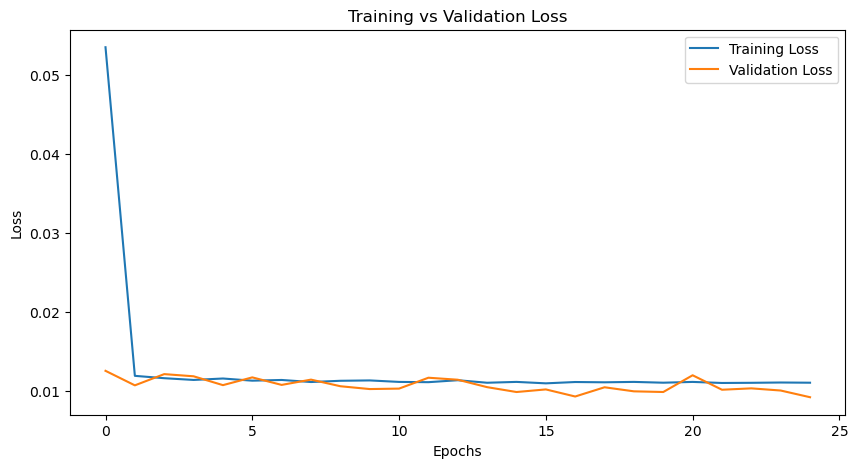

In [14]:
# Fit the model with the training data and validate with the validation data
history = model.fit(X_train, y_train,
                    batch_size=10,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[model_checkpoint, early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on Test Set

In [15]:
# Load the model
model = load_model("Data/LSTM/Saved_Models/lstm_single_u_target_diff_sequence_best_model")

# Make predictions on the test data
test_predictions = model.predict(X_test)

print("y_test shape:", y_test.shape)
print("test_predictions shape:", test_predictions.shape)

42/42 [==============================] - 2s 3ms/step
y_test shape: (1328,)
test_predictions shape: (1328, 1)


In [16]:
# Calculate metrics
mse_u = mean_squared_error(y_test, test_predictions)
m_ae_u = mean_absolute_error(y_test, test_predictions)
r2_u = r2_score(y_test, test_predictions)
explained_variance_u = explained_variance_score(y_test, test_predictions)

# Output the error metrics
print("Test MSE for 'u' component:", mse_u)
print("Test MAE for 'u' component:", m_ae_u)
print("Test R-squared for 'u' component:", r2_u)
print("Test Explained Variance for 'u' component:", explained_variance_u)

Test MSE for 'u' component: 0.002247271933715901
Test MAE for 'u' component: 0.028810413937697968
Test R-squared for 'u' component: 0.8288405611856697
Test Explained Variance for 'u' component: 0.8310535957343701


In [17]:
test_results = pd.DataFrame({
    'Test Predictions u': test_predictions.flatten(),
    'Actuals u': y_test
})

test_results

,Test Predictions u,Actuals u
0,0.100247,0.203187
1,0.200468,0.209414
2,0.207097,0.125163
3,0.128844,0.186031
4,0.187453,0.187845
...,...,...
1323,0.061528,0.003522
1324,0.001529,0.000774
1325,0.000145,-0.030468
1326,-0.029162,-0.026932


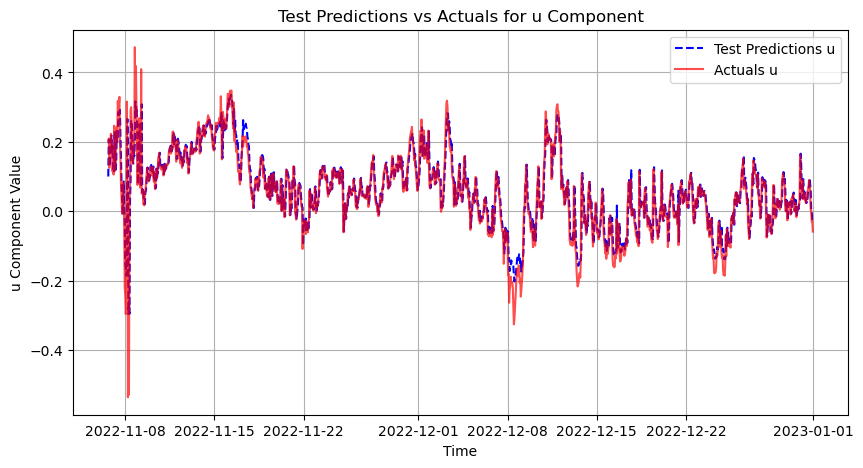

In [24]:
test_period_length = len(test_results)  
original_end_date = df_point['u'].index[-1]
original_freq = 'H'  

# Create a date range for the test period
test_dates = pd.date_range(end=original_end_date, periods=test_period_length, freq=original_freq)

# Assign this date range as the index of test_results
test_results.index = test_dates

plt.figure(figsize=(10, 5))
plt.plot(test_results.index, test_results['Test Predictions u'], label='Test Predictions u', color='blue', linestyle='--')
plt.plot(test_results.index, test_results['Actuals u'], label='Actuals u', color='red', alpha=0.7)
plt.title('Test Predictions vs Actuals for u Component')
plt.xlabel('Time')  
plt.ylabel('u Component Value')
plt.legend()
plt.grid(True)
plt.show()

### Making 24-Hour Predictions on the Test Set

First 24-Hour MSE: 0.0008436365682500116
First 24-Hour MAE: 0.022036280233158467
First 24-Hour R-squared: 0.5237833398563811
First 24-Hour Explained Variance: 0.5873359542987023


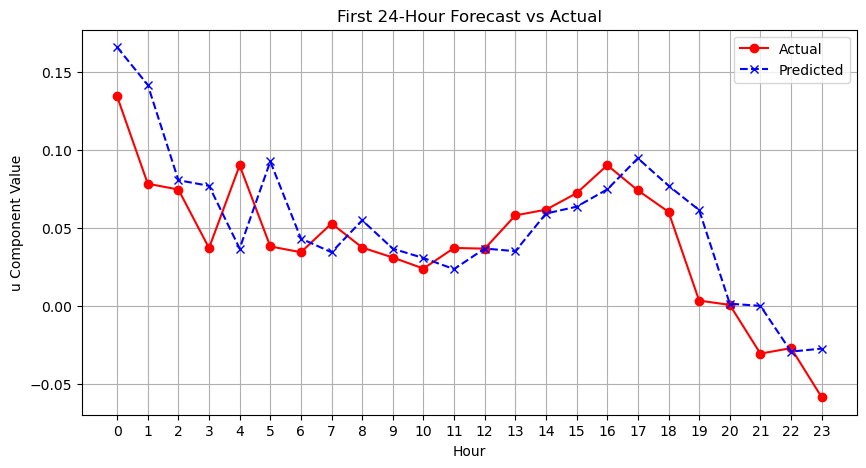

In [32]:
# Take the first 24 predictions for comparison
last_24_predictions = test_predictions[-24:]
last_24_actual = y_test[-24:]

# Flatten the predictions to make them a 1D array, if they're not already
first_24_predictions = last_24_predictions.flatten()

# Calculate metrics for the first 24-hour predictions
mse_24h = mean_squared_error(last_24_actual, first_24_predictions)
mae_24h = mean_absolute_error(last_24_actual, first_24_predictions)
r2_24h = r2_score(last_24_actual, first_24_predictions)
explained_variance_24h = explained_variance_score(last_24_actual, first_24_predictions)

# Output the error metrics for the 24-hour predictions
print("First 24-Hour MSE:", mse_24h)
print("First 24-Hour MAE:", mae_24h)
print("First 24-Hour R-squared:", r2_24h)
print("First 24-Hour Explained Variance:", explained_variance_24h)

# Plot for the first 24-hour predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(range(24), last_24_actual, label='Actual', marker='o', color='red')
plt.plot(range(24), first_24_predictions, label='Predicted', marker='x', color='blue', linestyle='--')
plt.title('First 24-Hour Forecast vs Actual')
plt.xlabel('Hour')
plt.ylabel('u Component Value')
plt.xticks(range(24)) 
plt.legend()
plt.grid(True)
plt.show()

### Making Real-Life prediction

In [ ]:
# Load input dataset
input_dataset = xr.open_dataset("Data/input_24_hours_data_SSC_Data.nc")
input_df = input_dataset.to_dataframe().reset_index()
input_df = input_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])
input_df['u'] = input_df['u'].astype('float32')
input_df['v'] = input_df['v'].astype('float32')
input_df.index = pd.to_datetime(input_df['time'], format='%d-%m-%Y %H:%M:%S')

# Remove rows where 'u' has NaN values
input_df = input_df.dropna(subset=['u'])
input_df = input_df.dropna(subset=['v'])

# Filter the DataFrame for the exact coordinates
df_point_input = input_df[(input_df['lat'] == target_lat) & (input_df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point_input

In [ ]:
# Load actual dataset
actual_dataset = xr.open_dataset("Data/actual_24_hours_data_SSC_Data.nc")
actual_df = actual_dataset.to_dataframe().reset_index()
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])
actual_df['u'] = actual_df['u'].astype('float32')
actual_df['v'] = actual_df['v'].astype('float32')
actual_df.index = pd.to_datetime(actual_df['time'], format='%d-%m-%Y %H:%M:%S')

# Remove rows where 'u' has NaN values
actual_df = actual_df.dropna(subset=['u'])
actual_df = actual_df.dropna(subset=['v'])

# Filter the DataFrame for the exact coordinates at the target latitude and longitude
df_point_actual = actual_df[(actual_df['lat'] == target_lat) & (actual_df['lon'] == target_lon)]

df_point_actual

In [ ]:
# Check if we have the latest 'u' and 'v' values
if len(df_point_input) >= window_size:
    # Assume the last row contains the latest 'u' and 'v' values
    last_row = df_point_input.iloc[-1]
    initial_input_features = np.array([[last_row['u'], last_row['v']]])  # Shape (1, 2)
else:
    print("Not enough data for initial prediction. Ensure at least 24 hours of data are available.")
    initial_input_features = None

predictions = []  # Initialize an empty list to store predictions

# Load the trained model
model = load_model("Data/LSTM/Saved_Models/lstm_test")

if initial_input_features is not None:
    for _ in range(24):  # Predicting the next 24 hours
        # Reshape the input features for the model: Shape should be (1, 1, 2)
        reshaped_input_features = initial_input_features.reshape(1, 1, 2)
        
        # Predict the next hour's 'u' value
        next_hour_prediction = model.predict(reshaped_input_features)
        predicted_u_value = next_hour_prediction.flatten()[0]  # Extract the predicted 'u' value
        
        # Store the prediction
        predictions.append(predicted_u_value)
        
        # Update the input features with the newly predicted 'u' value for the next prediction
        # Assume the last known 'v' value remains constant (update this as needed)
        last_known_v_value = initial_input_features[0, 1]
        initial_input_features = np.array([[predicted_u_value, last_known_v_value]])